# <center> <span style="color:orange"> Cryptos </span> </center>

### Fonctions utiles

### <span style="color:black"> Démarche utilisées : </span>

### ==> Nettoyage données
### ==> Definition de fonctions utiles
### ==> Affichage des données (graphes , Wordcloud )
### ==> Etude statistique (distribution et test statistique ) 
### ==> Mesure performance 
### ==> Conclusion

# ----------------------------------------- 2018 -----------------------------------------

In [253]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from scipy.stats import pearsonr, kstest
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
stop_words = set(stopwords.words('english'))
stop_words.update(['cryptos','etherium','cryptocurrency','cryptocurrencies','https','bitcoin', 'crypto',
                  'ethereum', 'market', 'btc','markets', 'news', 'article', 'trade', 'example', 'stock',
                  'value', 'hours', 'trading', 'consumers', 'movement', 'looking', 'last', 'exchange', 'girl',
                  'per', 'cent', 'per cent', 'lot', 'analysis', 'asset', 'correlation', 'month', 'volume',
                  'information', 'also', 'saw', 'many', 'day', 'one', 'retail', 'mortgage rate', 'look', 
                  'billion', 'said', 'think', 'last week'])

import re
r = re.compile(r"[^0-9]")

In [255]:
#affichage wordcloud
def plot_word_cloud(text, background_color = "black"):
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=200, 
                   stopwords = stop_words, 
                   max_font_size=50, random_state=42)
    # Générer et afficher le nuage de mots
    plt.figure(figsize= (13,7))
    wc.generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
#mesure de performance algo
def perform(result):
    print('Le ratio de Sharpe est : ' , result.sharpe)
    print('Le Beta est : ', result.alpha_beta()[1])

### Nettoyage données

In [256]:
#année 2018
S = pd.read_csv('cryptos/année_2018_DF.csv', index_col = 0, parse_dates = True)

In [257]:
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,LTC-USD_Close
Date,,,,,,,,
2017-12-01,10975.599609,466.540009,0.002118,2.07023,0.255699,0.002148,0.131352,99.003700
2017-12-02,11074.599609,463.449005,0.002073,2.08416,0.255492,0.002149,0.132351,100.283997
2017-12-03,11323.200195,465.852997,0.002116,2.22725,0.252558,0.002223,0.131807,101.263000
2017-12-04,11657.200195,470.204010,0.002144,2.49168,0.253571,0.002463,0.135870,104.236000
2017-12-05,11916.700195,463.281006,0.002085,2.59530,0.246101,0.002479,0.127488,102.397003


### Affichage données

In [258]:
from universal.algos import *


R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

In [259]:
#Configuration de l'affichage
plot_kwargs = {
    "logy": True,
    "assets": False,
    "weights": False,
    "ucrp": True,
}

In [260]:
#Configurer CRP pour du momentum
algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

In [261]:
#Configurer CRP pour de la reversion
algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

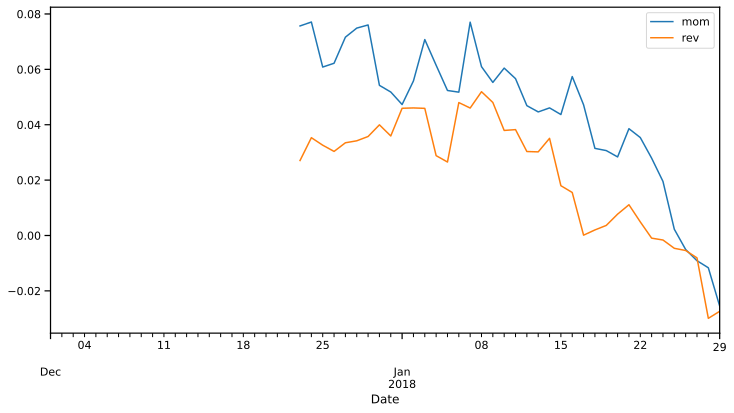

In [262]:
# meilleur performance, last 22 days
PERIOD = 22
performance = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance = performance.shift(1)

# plot performance
performance.plot()

### Etude statistique

<AxesSubplot:>

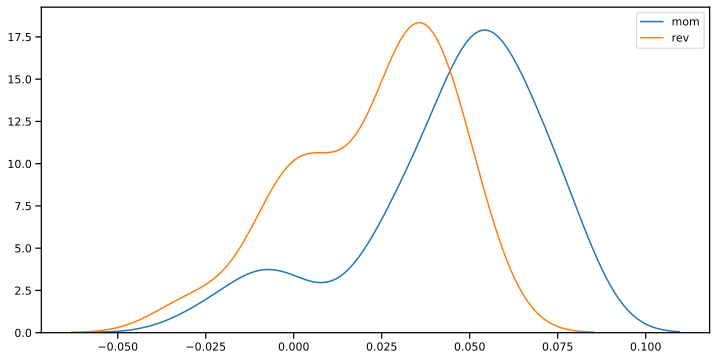

In [263]:
sns.kdeplot(performance['mom'])
sns.kdeplot(performance['rev'])

In [264]:
performance = performance.dropna()
pd.DataFrame(pearsonr(performance['mom'], performance['rev']), index=['pearson_coeff','p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,8.541083e-01
p-value,9.206621e-12


In [265]:
display(pd.DataFrame(kstest(performance['mom'],'norm'), index=['kolomogrov_coeff_mom','p-value'], columns=['resultat_test']))
display(pd.DataFrame(kstest(performance['rev'],'norm'), index=['kolomogrov_coeff_rev','p-value'], columns=['resultat_test']))

,resultat_test
kolomogrov_coeff_mom,4.898303e-01
p-value,6.245750e-09


,resultat_test
kolomogrov_coeff_rev,4.880668e-01
p-value,7.248233e-09


In [266]:
performance['difference'] = performance.mom - performance.rev

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/779607084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance['difference'] = performance.mom - performance.rev


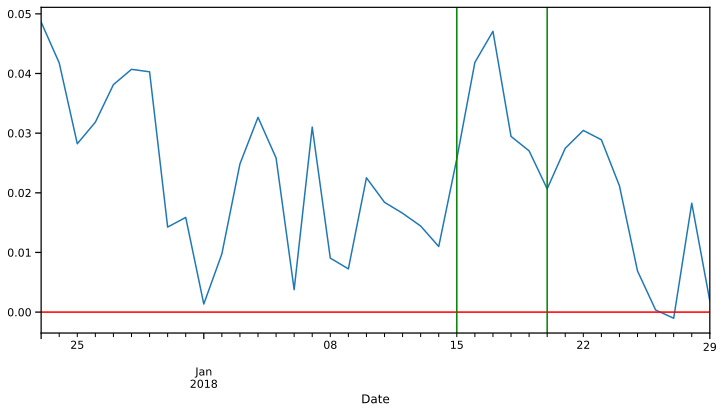

In [267]:
performance['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2018-01-15' , color = 'green')
plt.axvline(x = '2018-01-20' , color = 'green')

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/2322341472.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  performance['2018-01'].plot(ax = ax1)


<AxesSubplot:xlabel='Date'>

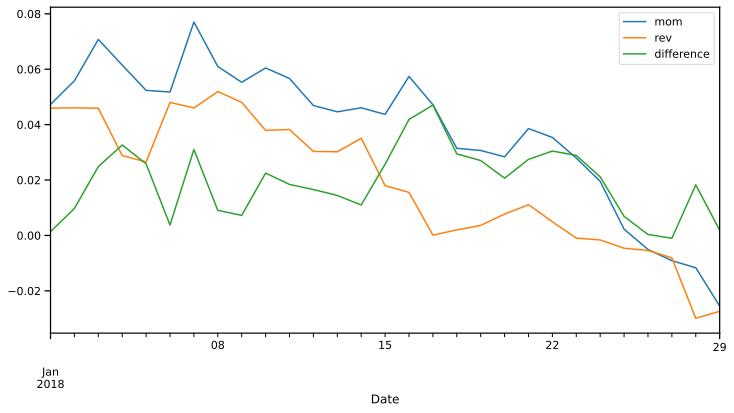

In [268]:
fig, ax1 = plt.subplots(1,1)
performance['2018-01'].plot(ax = ax1)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/4183107723.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  S['2018-01'].plot(ax = ax1)


<AxesSubplot:xlabel='Date'>

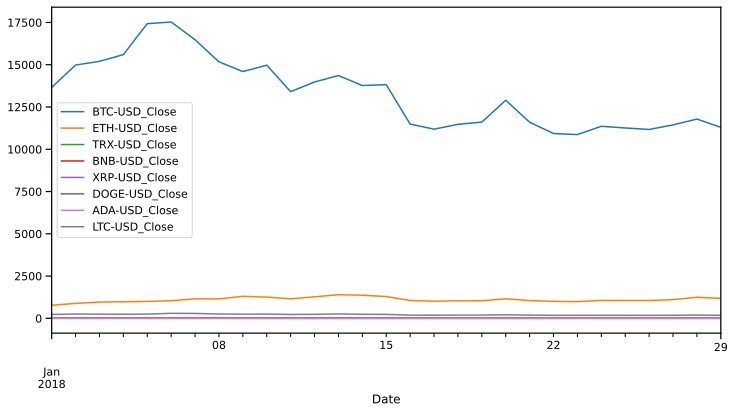

In [269]:
fig, ax1 = plt.subplots(1,1)
S['2018-01'].plot(ax = ax1)

In [270]:
R = pd.read_csv('cryptos/articles/articles_année_2018_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )


In [271]:
R = R.dropna()

In [272]:
R = R.astype({'Text': 'string'})

In [273]:
texte = " "
for e in R['Text'] : 
    texte += e

In [274]:
texte = re.sub('num', texte, texte)

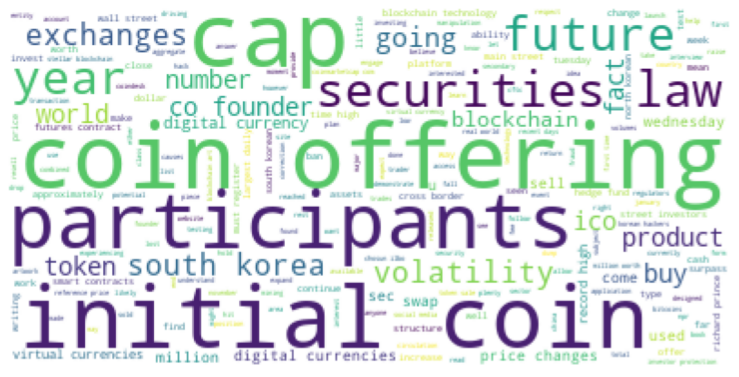

In [275]:
plot_word_cloud(texte.lower(), 'white')

In [276]:
print('pour reversion strategy : ', perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  3.1037570698799346
Le Beta est :  0.7408522696113136
pour reversion strategy :  None
Le ratio de Sharpe est :  6.284126257251484
Le Beta est :  0.9450026682596604
pour momentum strategy :  None


In [277]:
# construct new weight matrix from momentum and reversal
mom_better = (performance.mom > performance.rev)
rev_better = (performance.rev > performance.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 97.37% of time
Reversal is better 2.63% of time


Le ratio de Sharpe est :  3.238914645546784
Le Beta est :  0.5532969515133125
None


(17532.0, 17563.0)

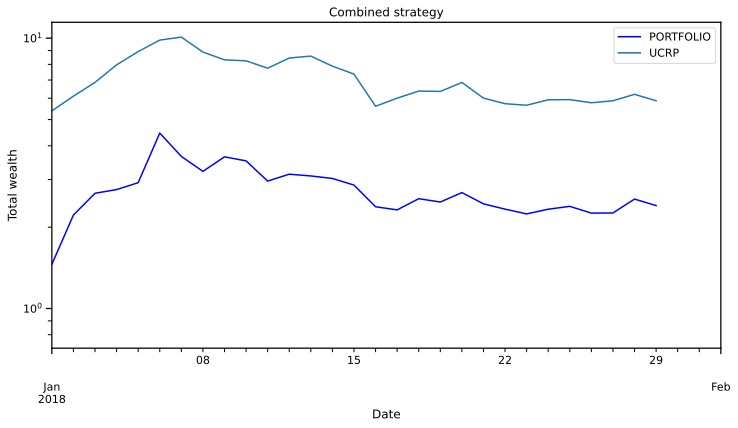

In [278]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(perform(result))
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')
plt.xlim(['2018-01','2018-02'])

In [279]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance['choix'] = performance['difference'].apply(lambda x : 1 if x > 0 else 0)

In [280]:
mome = [1]
reve = [0]

In [281]:
sharp_r = [result2.sharpe]
beta_r = [result2.alpha_beta()[1]]
sharp_m = [result1.sharpe]
beta_m = [result1.alpha_beta()[1]]

# -------------------------------------- 2018 flat -----------------------------------------

In [282]:
#année 2018
S = pd.read_csv('cryptos/année_2018_flat_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,LTC-USD_Close
Date,,,,,,,,
2018-09-01,7193.250000,295.341003,0.026590,11.3794,0.347721,0.006278,0.106827,65.950996
2018-09-02,7272.720215,294.371002,0.025572,11.2994,0.342523,0.004999,0.104432,65.649399
2018-09-03,7260.060059,289.259003,0.025037,11.2611,0.335961,0.005266,0.103607,65.373199
2018-09-04,7361.660156,285.722992,0.025255,11.3592,0.331652,0.005269,0.105265,67.709900
2018-09-05,6792.830078,232.330994,0.021810,10.0866,0.283601,0.004931,0.087569,58.437698


In [283]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

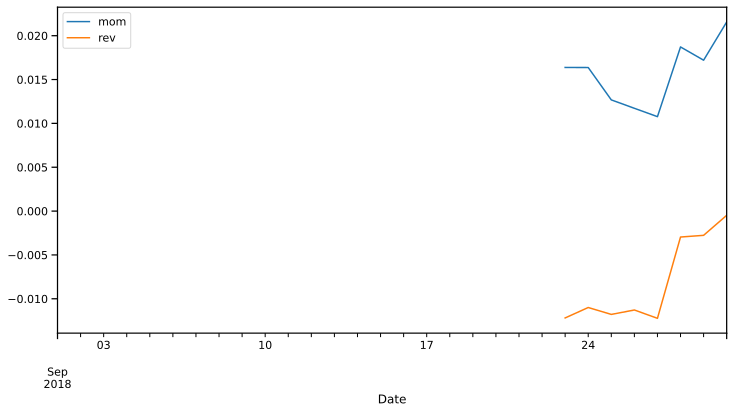

In [284]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance1 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance1 = performance1.shift(1)

# plot performance
performance1.plot()

<AxesSubplot:>

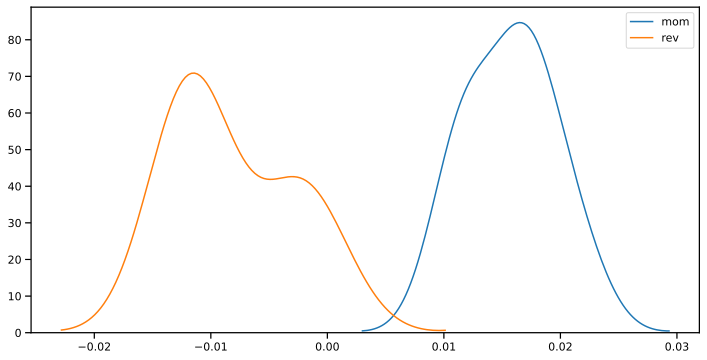

In [285]:
sns.kdeplot(performance1['mom'])
sns.kdeplot(performance1['rev'])

In [286]:
#test statistique
performance1 = performance1.dropna()
display(pd.DataFrame(pearsonr(performance1['mom'], performance1['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance1['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance1['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,0.821967
p-value,0.012291


,resultat_test
kolomogrov_coeff_mom,0.504296
p-value,0.020860


,resultat_test
kolomogrov_coeff_rev,0.500192
p-value,0.022511


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/1384710806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance1['difference'] = performance1.mom - performance1.rev


(17794.0, 17804.0)

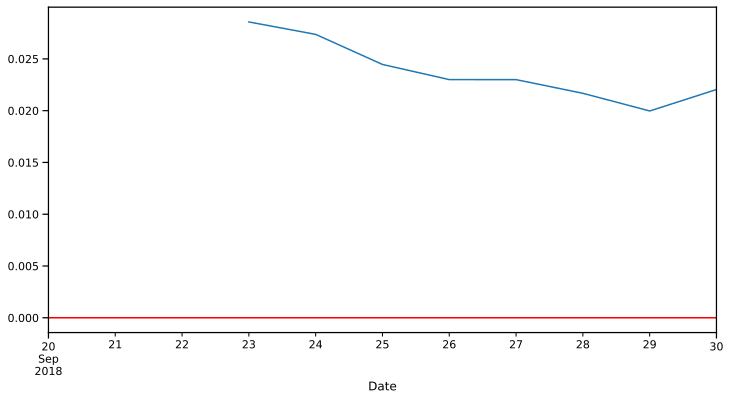

In [287]:
performance1['difference'] = performance1.mom - performance1.rev

performance1['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.xlim(['2018-09-20','2018-09-30'])

<AxesSubplot:xlabel='Date'>

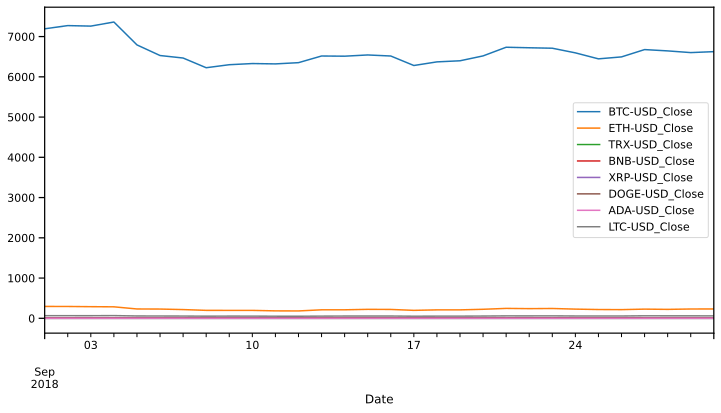

In [288]:
S.plot()

In [289]:
R = pd.read_csv('cryptos/articles/articles_année_2018_flat_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

In [290]:
T = pd.read_csv('cryptos/tweets/tweets_année_2018_flat_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

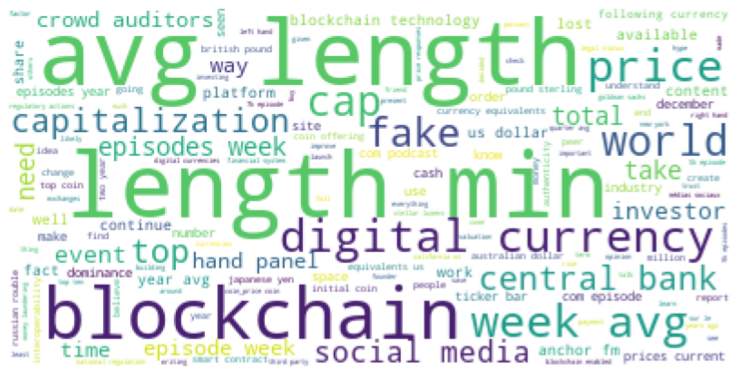

In [291]:
R = R.dropna()
R = R.astype({'Text': 'string'})
T = T.dropna()
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] :
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(), 'white')

In [292]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  -1.2034981855673335
Le Beta est :  0.6548697350914754
pour reversion strategy :  None
Le ratio de Sharpe est :  3.5157897804723084
Le Beta est :  1.3007453992144986
pour momentum strategy :  None


In [293]:
# construct new weight matrix from momentum and reversal
mom_better = (performance1.mom > performance1.rev)
rev_better = (performance1.rev > performance1.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 100.00% of time
Reversal is better 0.00% of time


In [294]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance1['choix'] = performance1['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/1579745738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance1['choix'] = performance1['difference'].apply(lambda x : 1 if x > 0 else 0)


In [295]:
mome.append(1)
reve.append(0)

In [296]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# ---------------------------------------- 2019 ----------------------------------------

In [297]:
#2019 flat
S = pd.read_csv('cryptos/année_2019_flat_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,LTC-USD_Close
Date,,,,,,,,
2019-01-01,3843.520020,140.819412,0.019561,6.075273,0.364771,0.002392,0.042547,31.979931
2019-01-02,3943.409424,155.047684,0.020222,6.188613,0.375243,0.002407,0.045258,33.433681
2019-01-03,3836.741211,149.135010,0.020088,5.903535,0.360224,0.002360,0.042682,32.026699
2019-01-04,3857.717529,154.581940,0.021492,6.065138,0.356747,0.002315,0.043812,32.404167
2019-01-05,3845.194580,155.638596,0.022294,6.065543,0.355275,0.002319,0.044701,34.936867


In [298]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

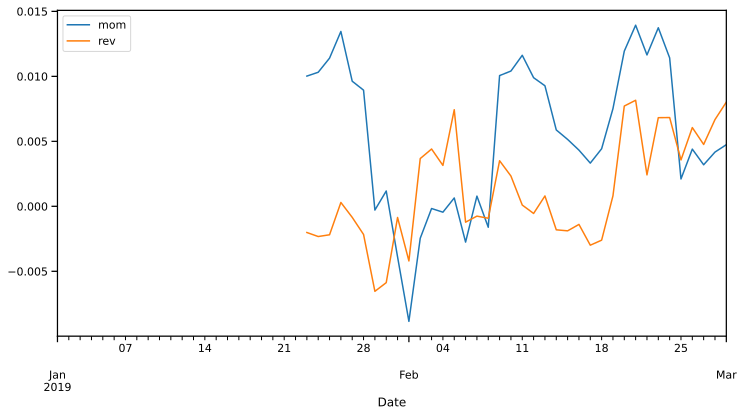

In [299]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance2 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance2 = performance2.shift(1)

# plot performance
performance2.plot()

<AxesSubplot:>

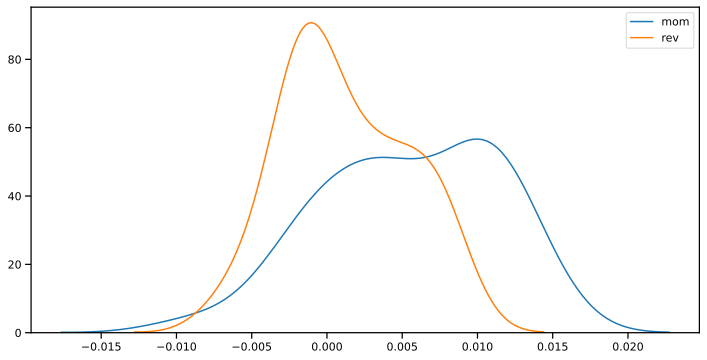

In [300]:
sns.kdeplot(performance2['mom'])
sns.kdeplot(performance2['rev'])

In [301]:
#test statistique
performance2 = performance2.dropna()
display(pd.DataFrame(pearsonr(performance2['mom'], performance2['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance2['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance2['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,0.264302
p-value,0.108823


,resultat_test
kolomogrov_coeff_mom,4.964688e-01
p-value,3.544413e-09


,resultat_test
kolomogrov_coeff_rev,4.973911e-01
p-value,3.273573e-09


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/4015489801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance2['difference'] = performance2.mom - performance2.rev


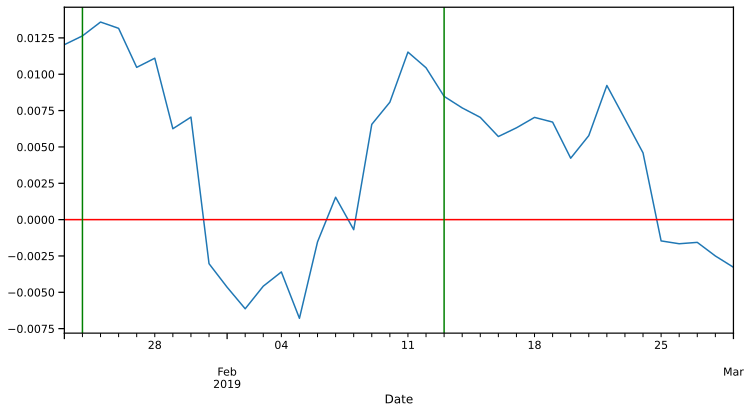

In [302]:
performance2['difference'] = performance2.mom - performance2.rev

performance2['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2019-01-24', color = 'green')
plt.axvline(x = '2019-02-13', color = 'green')

<AxesSubplot:xlabel='Date'>

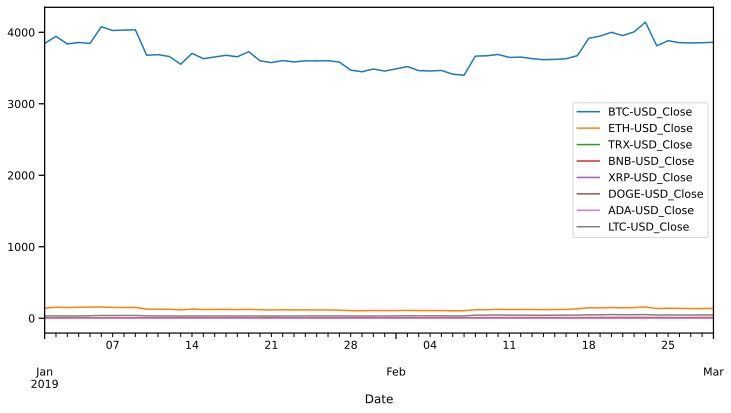

In [303]:
S.plot()

In [304]:
R = pd.read_csv('cryptos/articles/articles_année_2019_flat_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

In [305]:
T = pd.read_csv('cryptos/tweets/tweets_année_2019_flat_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

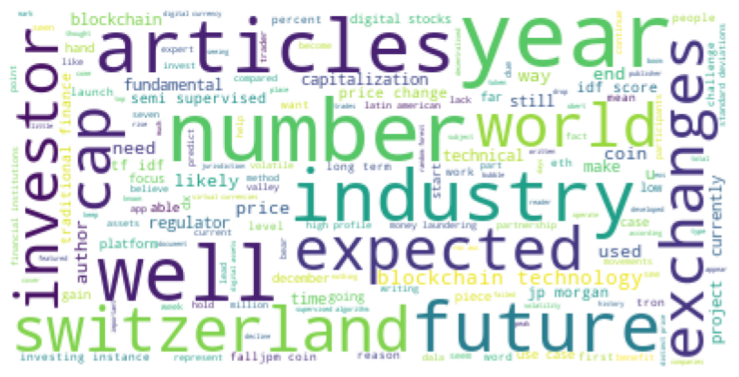

In [306]:
R = R.dropna()
T = T.dropna()
R = R.astype({'Text': 'string'})
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] :
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(), 'white')

In [307]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  1.0836829069036977
Le Beta est :  1.1007789421250882
pour reversion strategy :  None
Le ratio de Sharpe est :  2.649129382036643
Le Beta est :  1.3999609013357546
pour momentum strategy :  None


In [308]:
# construct new weight matrix from momentum and reversal
mom_better = (performance2.mom > performance2.rev)
rev_better = (performance2.rev > performance2.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 65.79% of time
Reversal is better 34.21% of time


In [309]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance2['choix'] = performance2['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/3480582597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance2['choix'] = performance2['difference'].apply(lambda x : 1 if x > 0 else 0)


In [310]:
mome.append(0)
reve.append(1)

In [311]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# ----------------------------------- 2021 Nov  -----------------------------------

In [312]:
#2021 Nov
S = pd.read_csv('cryptos/année_2021_Nov_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,SOL-USD_Close,SHIB-USD_Close,LTC-USD_Close
Date,,,,,,,,,,
2021-11-01,61004.406250,4324.626953,0.100548,551.255920,1.092867,0.271728,1.950002,203.545090,0.000072,197.554993
2021-11-02,63226.402344,4584.798828,0.107395,554.447632,1.136196,0.273121,1.971377,220.239594,0.000069,200.724686
2021-11-03,62970.046875,4607.193848,0.105863,568.578796,1.208796,0.269407,2.063701,242.898819,0.000055,207.110138
2021-11-04,61452.230469,4537.324219,0.103427,559.737305,1.202003,0.263280,1.984882,247.387772,0.000049,202.967987
2021-11-05,61125.675781,4486.243164,0.103719,608.648071,1.161533,0.261465,1.986206,236.474335,0.000062,199.537933


In [313]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

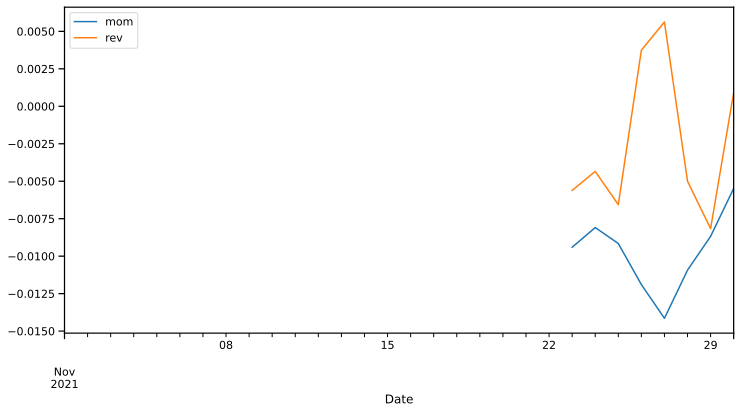

In [314]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance3 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance3 = performance3.shift(1)

# plot performance
performance3.plot()

<AxesSubplot:>

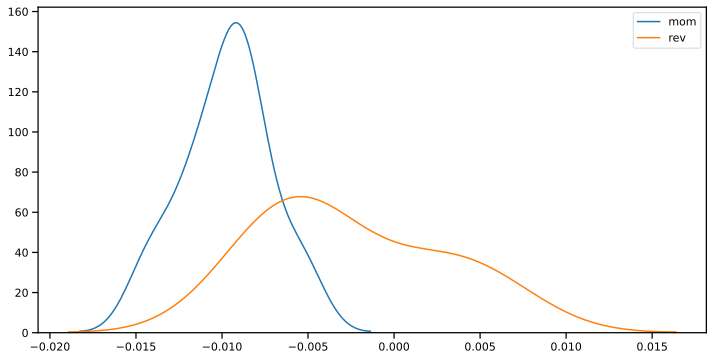

In [315]:
sns.kdeplot(performance3['mom'])
sns.kdeplot(performance3['rev'])

In [316]:
#test statistique
performance3 = performance3.dropna()
display(pd.DataFrame(pearsonr(performance3['mom'], performance3['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance3['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance3['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,-0.470677
p-value,0.239159


,resultat_test
kolomogrov_coeff_mom,0.502188
p-value,0.021694


,resultat_test
kolomogrov_coeff_rev,0.497756
p-value,0.023542


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/2248109877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance3['difference'] = performance3.mom - performance3.rev


(18954.0, 18961.0)

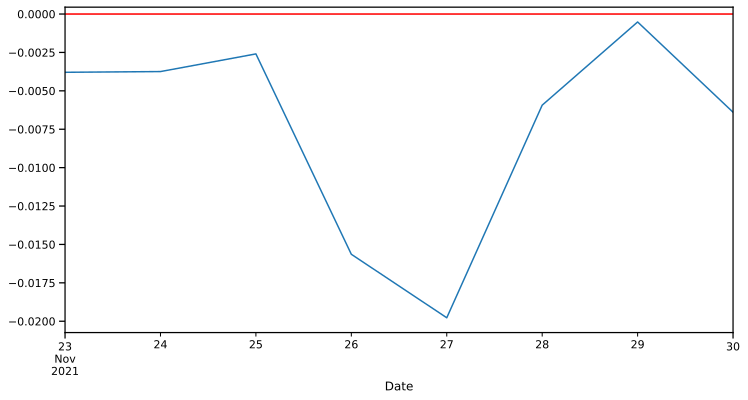

In [317]:
performance3['difference'] = performance3.mom - performance3.rev

performance3['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.xlim(['2021-11-23','2021-11-30'])

<AxesSubplot:xlabel='Date'>

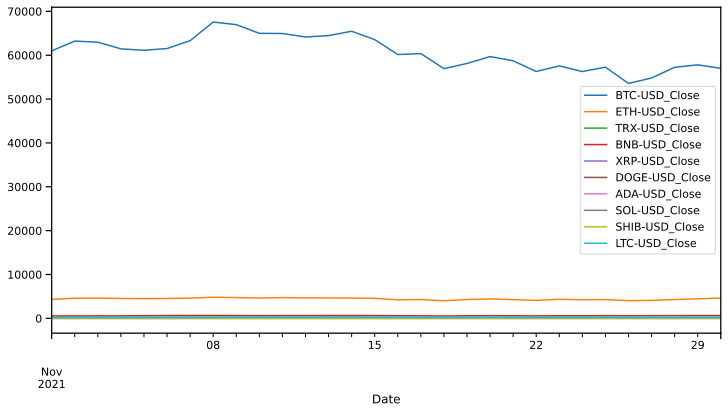

In [318]:
S.plot()

In [319]:
R = pd.read_csv('cryptos/articles/articles_année_2021_Nov_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

In [320]:
T = pd.read_csv('cryptos/tweets/tweets_année_2021_Nov_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

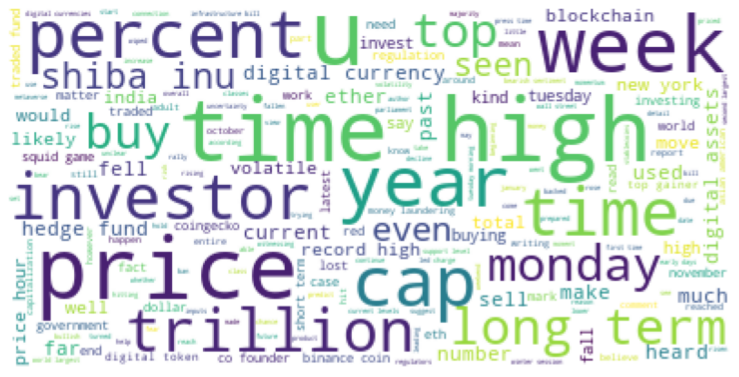

In [321]:
R = R.dropna()
T = T.dropna()
R = R.astype({'Text': 'string'})
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] :
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(), 'white')

In [322]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.4252244213358606
Le Beta est :  1.5950875671247364
pour reversion strategy :  None
Le ratio de Sharpe est :  -0.8524359703351274
Le Beta est :  0.8556797032100243
pour momentum strategy :  None


In [323]:
# construct new weight matrix from momentum and reversal
mom_better = (performance3.mom > performance3.rev)
rev_better = (performance3.rev > performance3.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 0.00% of time
Reversal is better 100.00% of time


In [324]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance3['choix'] = performance3['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/1719321890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance3['choix'] = performance3['difference'].apply(lambda x : 1 if x > 0 else 0)


In [325]:
mome.append(0)
reve.append(1)

In [326]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# ----------------------------------- 2021 Oct  --------------------------------------

In [327]:
#2021 Oct
S = pd.read_csv('cryptos/année_2021_Oct_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,SOL-USD_Close,SHIB-USD_Close,LTC-USD_Close
Date,,,,,,,,,,
2021-09-28,41034.542969,2807.296631,0.083145,333.032593,0.893689,0.196804,2.039139,131.537216,0.000007,140.597122
2021-09-29,41564.363281,2853.143311,0.085946,367.989594,0.928349,0.198876,2.065688,135.351456,0.000007,144.918625
2021-09-30,43790.894531,3001.678955,0.089426,387.057343,0.952636,0.204244,2.114452,141.069046,0.000007,153.147995
2021-10-01,48116.941406,3307.516113,0.094732,421.643188,1.042624,0.223010,2.258127,161.682373,0.000008,166.132202
2021-10-02,47711.488281,3391.694336,0.093627,428.098328,1.038675,0.219133,2.251459,169.093018,0.000008,169.258926


In [328]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

(18919.0, 18927.0)

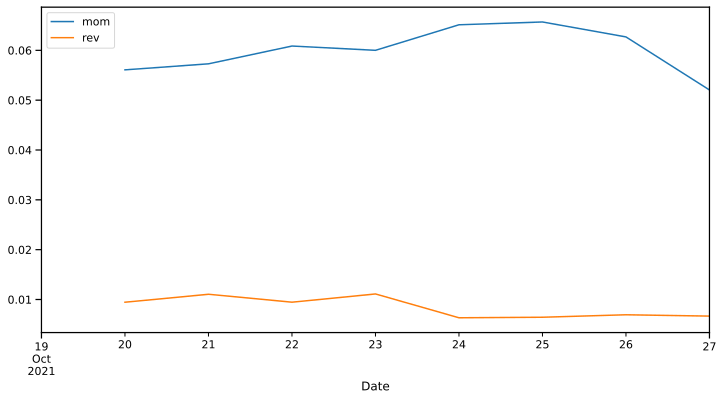

In [329]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance4 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance4 = performance4.shift(1)

# plot performance
performance4.plot()
plt.xlim(['2021-10-19','2021-10-27'])

<AxesSubplot:>

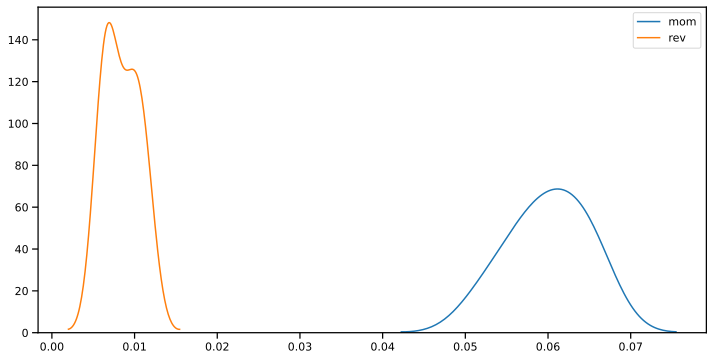

In [330]:
sns.kdeplot(performance4['mom'])
sns.kdeplot(performance4['rev'])

In [331]:
#test statistique
performance4 = performance4.dropna()
display(pd.DataFrame(pearsonr(performance4['mom'], performance4['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance4['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance4['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,-0.330314
p-value,0.424237


,resultat_test
kolomogrov_coeff_mom,0.520753
p-value,0.015237


,resultat_test
kolomogrov_coeff_rev,0.502527
p-value,0.021558


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/3655715835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance4['difference'] = performance4.mom - performance4.rev


(18919.0, 18927.0)

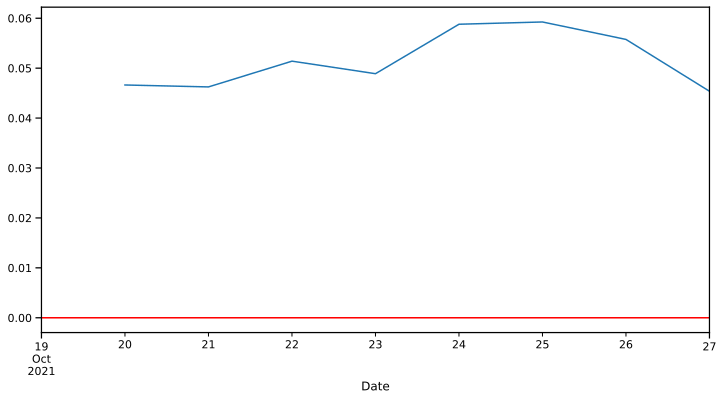

In [332]:
performance4['difference'] = performance4.mom - performance4.rev

performance4['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.xlim(['2021-10-19','2021-10-27'])

<AxesSubplot:xlabel='Date'>

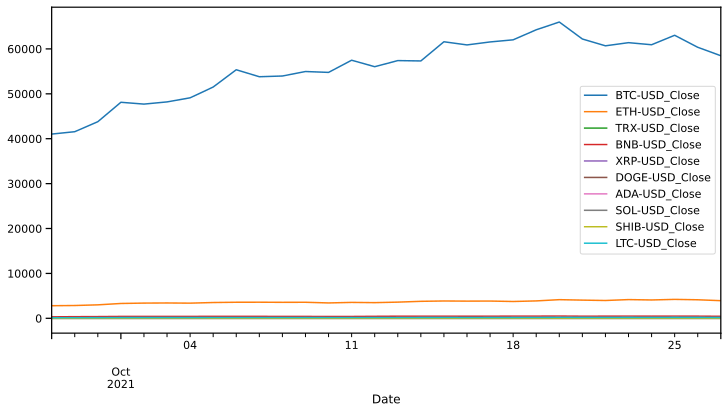

In [333]:
S.plot()

In [334]:
R = pd.read_csv('cryptos/articles/articles_année_2021_Oct_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

In [335]:
T = pd.read_csv('cryptos/tweets/tweets_année_2021_Nov_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )

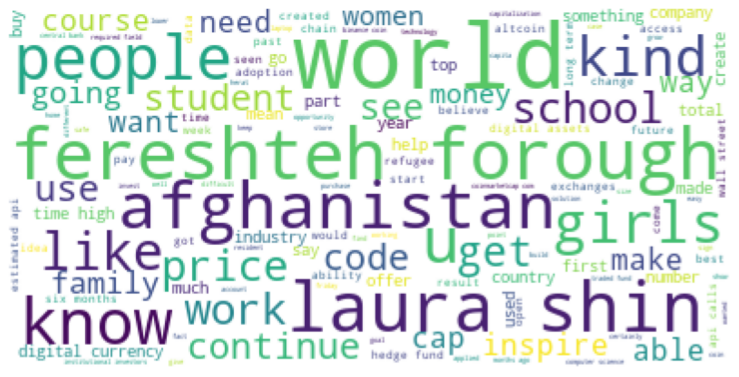

In [336]:
R = R.dropna()
T = T.dropna()
R = R.astype({'Text': 'string'})
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] : 
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(), 'white')

In [337]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  2.5312239445712725
Le Beta est :  0.5027297323161607
pour reversion strategy :  None
Le ratio de Sharpe est :  9.207299687509009
Le Beta est :  2.403473221388868
pour momentum strategy :  None


In [338]:
# construct new weight matrix from momentum and reversal
mom_better = (performance3.mom > performance3.rev)
rev_better = (performance3.rev > performance3.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 0.00% of time
Reversal is better 100.00% of time


In [339]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance4['choix'] = performance4['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/4006362847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance4['choix'] = performance4['difference'].apply(lambda x : 1 if x > 0 else 0)


In [340]:
mome.append(0)
reve.append(1)
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# --------------------------------------- covid  --------------------------------------

In [341]:
#covid
S = pd.read_csv('cryptos/covid_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,LTC-USD_Close
Date,,,,,,,,
2019-11-11,8757.788086,185.489639,0.019096,20.133141,0.275086,0.002715,0.043194,61.899109
2019-11-12,8815.662109,186.843414,0.019614,20.857447,0.272418,0.002725,0.043767,61.340298
2019-11-13,8808.262695,188.258743,0.020113,21.250431,0.273036,0.002698,0.043492,61.111347
2019-11-14,8708.094727,185.999634,0.019509,21.264700,0.270391,0.002680,0.043119,59.429893
2019-11-15,8491.992188,180.521179,0.018617,20.316225,0.261654,0.002657,0.043974,57.811710


In [342]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

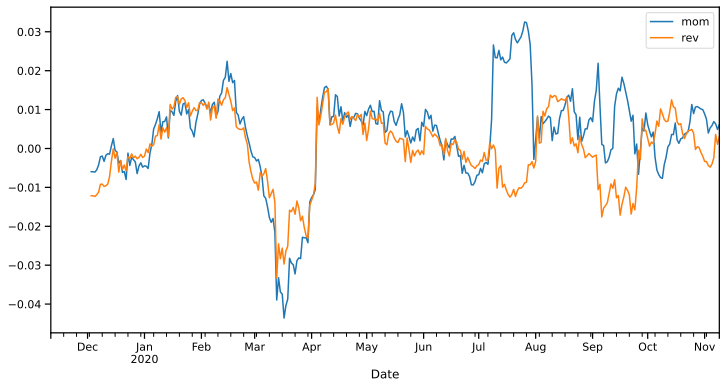

In [343]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance5 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance5 = performance5.shift(1)

# plot performance
performance5.plot()

<AxesSubplot:>

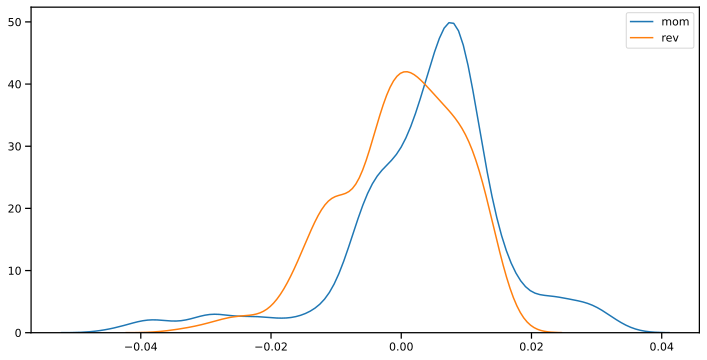

In [344]:
sns.kdeplot(performance5['mom'])
sns.kdeplot(performance5['rev'])

In [345]:
#test statistique
performance5 = performance5.dropna()
display(pd.DataFrame(pearsonr(performance5['mom'], performance5['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance5['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance5['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,5.056396e-01
p-value,1.157910e-23


,resultat_test
kolomogrov_coeff_mom,4.870294e-01
p-value,1.744949e-75


,resultat_test
kolomogrov_coeff_rev,4.937609e-01
p-value,1.026553e-77


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/893899321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance5['difference'] = performance5.mom - performance5.rev


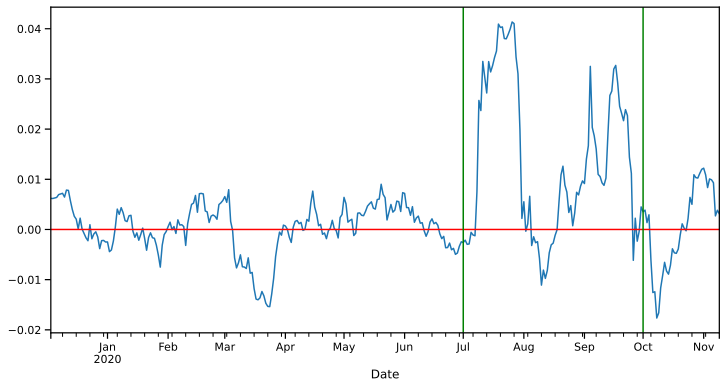

In [346]:
performance5['difference'] = performance5.mom - performance5.rev

performance5['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2020-07',color = 'green')
plt.axvline(x = '2020-10', color = 'green')

<AxesSubplot:xlabel='Date'>

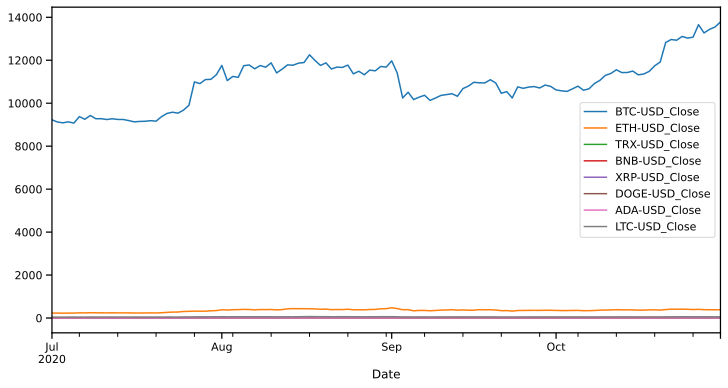

In [347]:
S['2020-07':'2020-10'].plot()

In [348]:
R = pd.read_csv('cryptos/articles/articles_covid_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )
R = R['2020-07':'2020-10']

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/271379481.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  R = R['2020-07':'2020-10']


In [349]:
T = pd.read_csv('cryptos/tweets/tweets_année_2021_Nov_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )
T = T['2020-07':'2020-10']

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/688338685.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  T = T['2020-07':'2020-10']


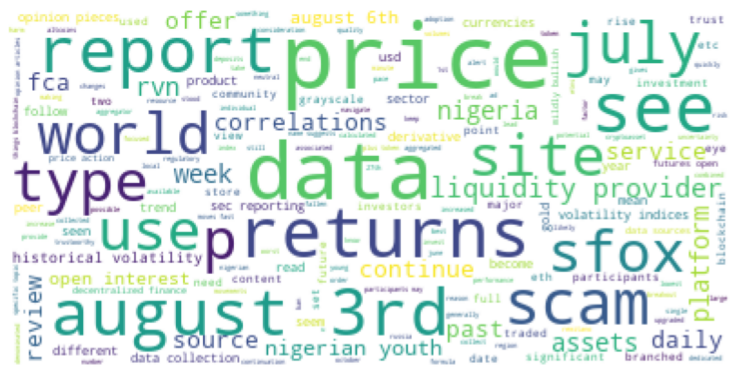

In [350]:
R = R.dropna()
T = T.dropna()
R = R.astype({'Text': 'string'})
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] : 
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(), 'white')

In [351]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.31085005738948973
Le Beta est :  0.9972385820059197
pour reversion strategy :  None
Le ratio de Sharpe est :  1.5986126444638704
Le Beta est :  1.034974107486608
pour momentum strategy :  None


In [352]:
# construct new weight matrix from momentum and reversal
mom_better = (performance5.mom > performance5.rev)
rev_better = (performance5.rev > performance5.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 62.39% of time
Reversal is better 37.61% of time


In [353]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance5['choix'] = performance5['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/849530315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance5['choix'] = performance5['difference'].apply(lambda x : 1 if x > 0 else 0)


In [354]:
mome.append(1)
reve.append(0)
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# --------------------------------- Guerre en Ukraine  ---------------------------------

In [355]:
#guerre ukraine
S = pd.read_csv('cryptos/ukr_war_DF.csv', index_col = 0, parse_dates = True)
liste = []
for clo in S.columns:
    if "Close" in clo:
        liste.append(clo)
S = S[liste]
S = S.dropna(axis = 1)
S.head()

,BTC-USD_Close,ETH-USD_Close,TRX-USD_Close,BNB-USD_Close,XRP-USD_Close,DOGE-USD_Close,ADA-USD_Close,SOL-USD_Close,SHIB-USD_Close,LTC-USD_Close
Date,,,,,,,,,,
2022-02-24,38332.609375,2598.067139,0.061121,361.234650,0.696272,0.123813,0.853425,89.194748,0.000024,104.230492
2022-02-25,39214.218750,2764.535645,0.059496,374.914948,0.768903,0.127576,0.898027,92.598824,0.000025,109.266312
2022-02-26,39105.148438,2781.111816,0.059530,373.638763,0.750973,0.127647,0.887918,90.141563,0.000024,108.243660
2022-02-27,37709.785156,2621.801758,0.058053,360.531036,0.721992,0.123111,0.858335,85.519051,0.000023,103.105598
2022-02-28,43193.234375,2919.201172,0.061749,395.612427,0.782044,0.133156,0.959828,99.520348,0.000026,113.474579


In [356]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

(19066.0, 19112.0)

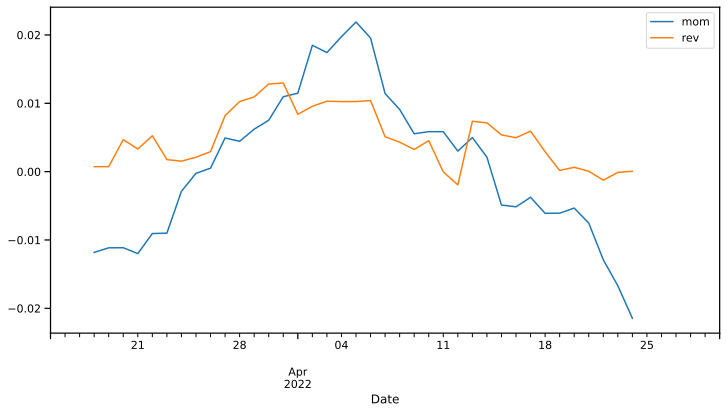

In [357]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance6 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance6 = performance6.shift(1)

# plot performance
performance6.plot()
plt.xlim(['2022-03-15','2022-04-30'])

<AxesSubplot:>

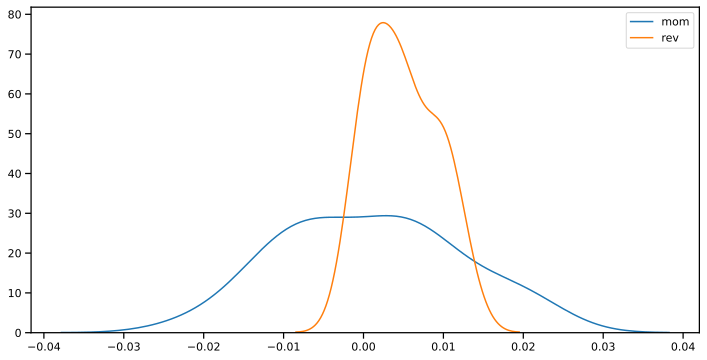

In [358]:
sns.kdeplot(performance6['mom'])
sns.kdeplot(performance6['rev'])

In [359]:
#test statistique
performance6 = performance6.dropna()
display(pd.DataFrame(pearsonr(performance6['mom'], performance6['rev']), 
                     index=['pearson_coeff','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance6['mom'],'norm'), 
                     index=['kolomogrov_coeff_mom','p-value'], 
                     columns=['resultat_test']))
display(pd.DataFrame(kstest(performance6['rev'],'norm'), 
                     index=['kolomogrov_coeff_rev','p-value'], 
                     columns=['resultat_test']))

,resultat_test
pearson_coeff,7.224240e-01
p-value,3.043998e-07


,resultat_test
kolomogrov_coeff_mom,4.914382e-01
p-value,5.449856e-09


,resultat_test
kolomogrov_coeff_rev,4.992282e-01
p-value,2.792612e-09


/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/2905918205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance6['difference'] = performance6.mom - performance6.rev


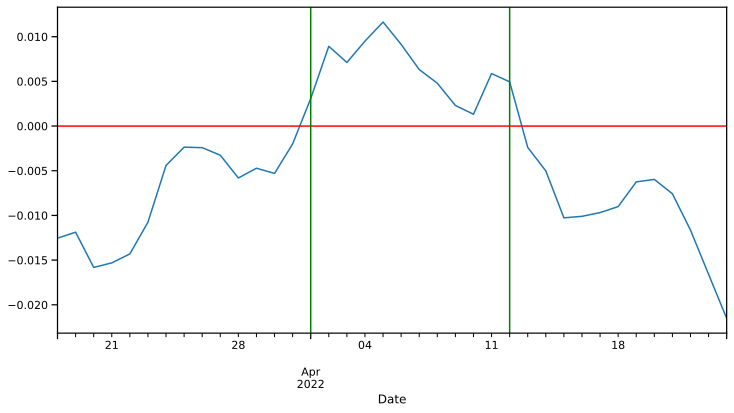

In [360]:
performance6['difference'] = performance6.mom - performance6.rev

performance6['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2022-04-01',color = 'green')
plt.axvline(x = '2022-04-12', color = 'green')

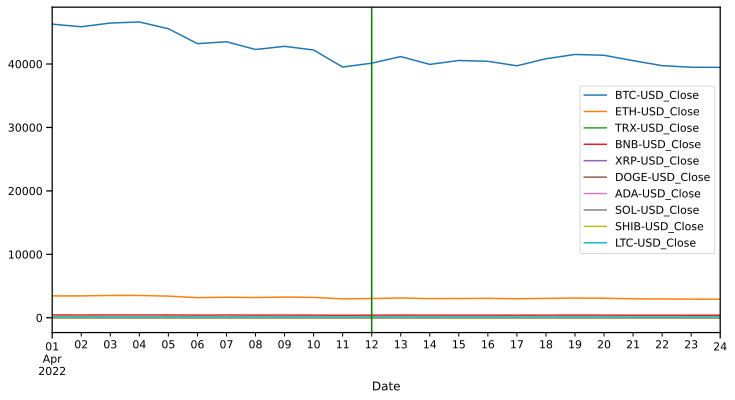

In [361]:
S['2022-04-01':'2022-04-24'].plot()
plt.axvline(x = '2022-04-12', color = 'green')

In [362]:
R = pd.read_csv('cryptos/articles/articles_ukr_war_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )
R = R['2022-04-1':'2022-04-12']

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/3456016933.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  R = R['2022-04-1':'2022-04-12']


In [363]:
T = pd.read_csv('cryptos/tweets/tweets_année_2021_Nov_DF.csv', on_bad_lines='skip', 
                index_col = 0, parse_dates = True, sep = '\t' )
T = T['2022-04-1':'2022-04-12']

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/3870216123.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  T = T['2022-04-1':'2022-04-12']


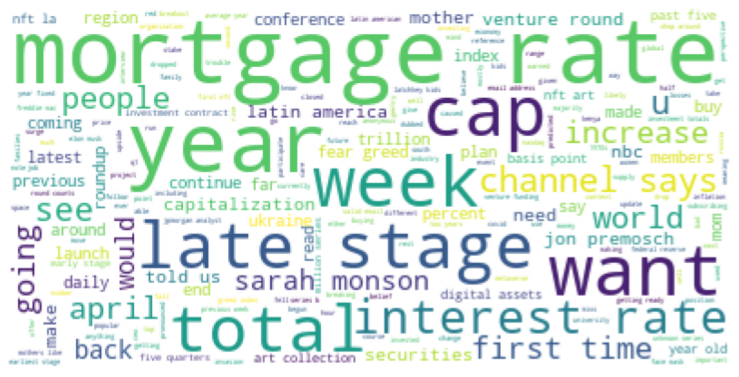

In [364]:
R = R.dropna()
T = T.dropna()
R = R.astype({'Text': 'string'})
texte = " "
for e in R['Text'] : 
    texte += e
for k in T['Tweet'] : 
    texte += k
texte = re.sub('num', texte, texte)
plot_word_cloud(texte.lower(),'white')

In [365]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  1.845386484384342
Le Beta est :  1.126718844715192
pour reversion strategy :  None
Le ratio de Sharpe est :  -2.0369462714106477
Le Beta est :  1.1658880853211842
pour momentum strategy :  None


In [366]:
# construct new weight matrix from momentum and reversal
mom_better = (performance6.mom > performance6.rev)
rev_better = (performance6.rev > performance6.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 31.58% of time
Reversal is better 68.42% of time


In [367]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance6['choix'] = performance6['difference'].apply(lambda x : 1 if x > 0 else 0)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2713/1399327890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance6['choix'] = performance6['difference'].apply(lambda x : 1 if x > 0 else 0)


In [368]:
mome.append(0)
reve.append(1)
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# Bilan

In [369]:
summary_table = pd.DataFrame(list(zip(mome,reve,sharp_r,beta_r,sharp_m,sharp_m)), 
                     columns = ['momentum', 'mean reversion','Sharp mean reversion','Beta mean reversion', 'Sharp momentum','beta momentum'], 
                     index = ['Année 2018', 'Année 2018 flat', 'Année 2019 flat','Année 2019 Novembre','Année 2019 Octobre', 'Covid19', 'Guerre Ukrainienne'])

In [370]:
summary_table

,momentum,mean reversion,Sharp mean reversion,Beta mean reversion,Sharp momentum,beta momentum
Année 2018,1,0,3.103757,0.740852,6.284126,6.284126
Année 2018 flat,1,0,-1.203498,0.654870,3.515790,3.515790
Année 2019 flat,0,1,1.083683,1.100779,2.649129,2.649129
Année 2019 Novembre,0,1,0.425224,1.595088,-0.852436,-0.852436
Année 2019 Octobre,0,1,2.531224,0.502730,9.207300,9.207300
Covid19,1,0,0.310850,0.997239,1.598613,1.598613
Guerre Ukrainienne,0,1,1.845386,1.126719,-2.036946,-2.036946


### Les algos de type momentum paraît puissant pour des périodes à grande volatilité  ( Covid par exemple ) .
### Les algos de type mean reversion sont par contre efficace pour des périodes stables .